<a href="https://colab.research.google.com/github/gknelsonn/computer_vision/blob/main/maize_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CORN OR MAIZE LEAF DISEASE PREDICTION MODEL**
Dataset: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/data


**Import necessary tools/libraries**

In [ ]:
!pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


Mount google drive for the upload of our dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After locating our dataset and identifying the path on the Google Drive, we use `tf.keras.utils.image_dataset_from_directory` to load the dataset. This function is designed to load images from a directory structure where subdirectories represent different classes.

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset_path ='/content/drive/MyDrive/maize_ disease' #the dataset path

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True, #shuffle the data
)

Found 4188 files belonging to 4 classes.


**Hurray!!** We have successfully loaded the data!

Now, let's inspect the data

In [ ]:
for images, labels in dataset.take(1):
  print(images.shape)
  print(labels.shape)
  print(labels.numpy())

(32, 256, 256, 3)
(32,)
[1 2 0 2 3 3 1 0 1 1 1 3 1 2 2 2 2 3 1 3 3 0 1 3 2 3 0 3 2 3 1 0]


The dataset is leaded in batches(32), so we take 1 batch. The labels are represented by integers. The order of the label corresponds to the order of the images in the images tensor for this batch.




In [ ]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# **Visualization**

Let's now visualize the dataset

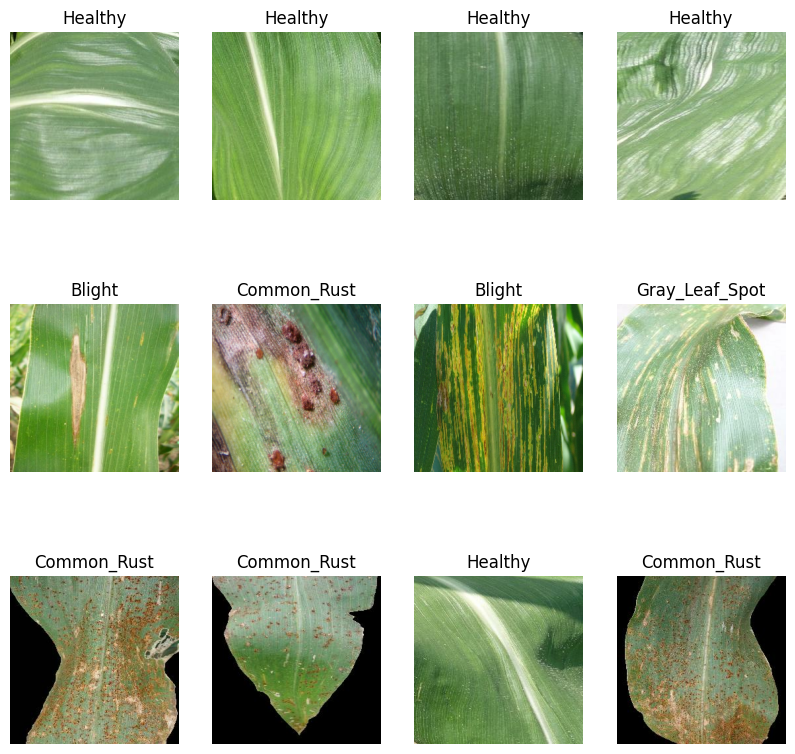

In [ ]:
plt.figure(figsize=(10, 10)) #total size of the plot
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

131

In [ ]:
train_size = 0.8
len(dataset)*train_size

104.80000000000001

For training, we are going to use 104 batches!

In [ ]:
train_ds = dataset.take(104)
len(train_ds)

104

In [ ]:
test_ds = dataset.skip(104)
len(test_ds)

27

We use `dataset.skip(104)` to create a new test dataset. This test dataset will contain all the batches from your original starting from the 104th batch.

In [ ]:
val_size=0.1
len(dataset)*val_size

13.100000000000001

In [ ]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [ ]:
test_ds = test_ds.skip(13)
len(test_ds)

14

Now we create a function to split our TensorFlow dataset `(tf.data.Dataset)` into training, validation, and testing subsets.

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# **Cache, Shuffle, and Prefetch the Dataset**


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building the Model**
**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Resizing, Rescaling
resize_and_rescale = tf.keras.Sequential([
  Resizing(IMAGE_SIZE, IMAGE_SIZE), # Import Resizing directly
  Rescaling(1./255), # Import Rescaling directly
])

**Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
from tensorflow.keras import layers
# Import RandomFlip and RandomRotation directly from tensorflow.keras.layers
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = tf.keras.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**

We use `adam` Optimizer, `SparseCategoricalCrossentrop`y for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

*The moment of truth...*

In [ ]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.4325 - loss: 1.1566 - val_accuracy: 0.6971 - val_loss: 0.8078
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.7747 - loss: 0.5790 - val_accuracy: 0.8149 - val_loss: 0.3896
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.8172 - loss: 0.4386 - val_accuracy: 0.8245 - val_loss: 0.3641
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.8402 - loss: 0.4060 - val_accuracy: 0.8149 - val_loss: 0.4304
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.8285 - loss: 0.4172 - val_accuracy: 0.8726 - val_loss: 0.3424
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8615 - loss: 0.3401 - val_accuracy: 0.8341 - val_loss: 0.3688
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8395 - loss: 0.3557 - val_accuracy: 0.8774 - val_loss: 0.3149
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.8710 - loss: 0.3221 - val_accu

Our accuracy is **86%**; which is quite good. We could have done better but because of limited resources we can work with that.

In [ ]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 708ms/step - accuracy: 0.8858 - loss: 0.2335


In [ ]:
scores

[0.25481662154197693, 0.8839285969734192]

**Plotting the accuracy and loss curves**

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 104}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

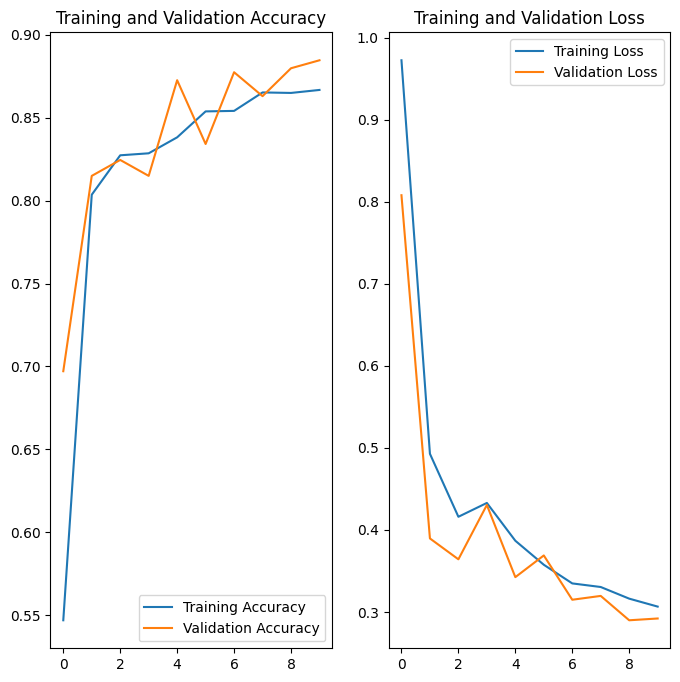

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plotted curves show how well the model performed during training (blue line) and on unseen data (orange line) over each training cycle (epoch). The left plot tracks the accuracy, indicating the percentage of correct predictions. The right plot shows the loss, representing the error of the model's predictions. Ideally, you want the training accuracy to increase, the validation accuracy to follow closely, and both the training and validation loss to decrease over time.

# **Run the prediction on a sample image**

first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
predicted label: Common_Rust


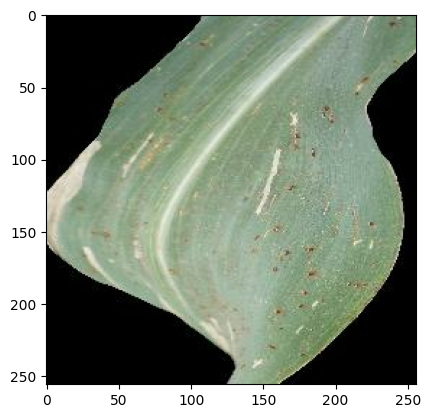

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **Write a function for inference**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run the inference on some few samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


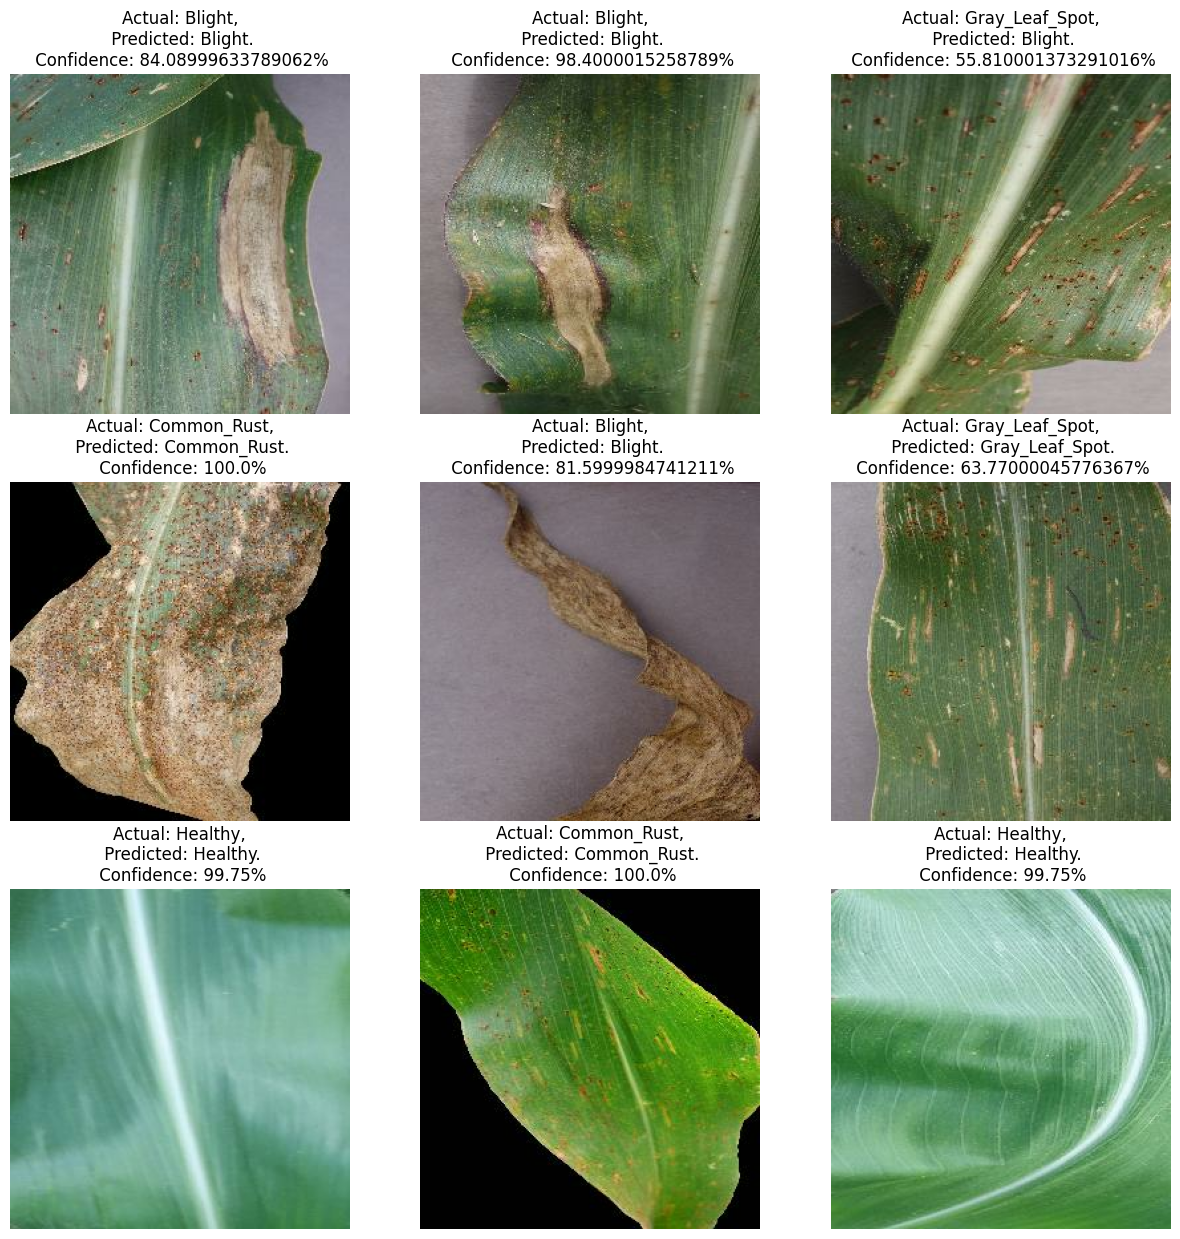

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

The results are **MAGNIFICENT!! HURRAY!!**

Finally, let's save the model

In [ ]:
import os

# Specify the directory on your Google Drive
model_dir_drive = "/content/drive/MyDrive/saved_models"


if not os.path.exists(model_dir_drive):
    os.makedirs(model_dir_drive)


model_path_drive = os.path.join(model_dir_drive, "my_corn_disease_model.keras")

# Save the model to Google Drive with the specified path and extension
model.save(model_path_drive)

print(f"Model saved successfully to: {model_path_drive}")

Model saved successfully to: /content/drive/MyDrive/saved_models/my_corn_disease_model.keras


Let's the model in one file(HDF5) for ease of deployment

In [ ]:
model_dir_drive = "/content/drive/MyDrive/saved_models"

if not os.path.exists(model_dir_drive):
    os.makedirs(model_dir_drive)

# Specify the full path with the .h5 extension on Google Drive
model_path_h5 = os.path.join(model_dir_drive, "my_corn_disease_model.h5")

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(model_path_h5)

print(f"Model saved successfully to: {model_path_h5}")



Model saved successfully to: /content/drive/MyDrive/saved_models/my_corn_disease_model.h5
